<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_11_Light_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.datasets import mnist, cifar10
from keras.layers import BatchNormalization, MaxPooling2D, concatenate, Embedding
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, UpSampling2D, Conv2D
from keras.layers import multiply, LeakyReLU, Activation, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import plot_model

import matplotlib.pyplot as plt

import sys

import numpy as np

#Light задание. Вариант 1
----
Используя шаблон ноутбука, напишите генеративную сеть для генерации рукописных цифр. Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками

Почему параметр импульса (momentum, второй параметр в Adam) не рекомендуется ставить больше 0.5 в генеративных сетях
Дело в том, что momentum отвечает за "ускорение" при градиентном спуске. В обычных задачах гиперповерхность loss функции не меняется, и ускоряться при спуске безопасно. В GAN же для двух моделей гиперповерхность постоянно меняется, так как модели соревнуются, поэтому возможны случаи, когда происходит ускорение с помощью momentum, а затем меняется поверхность, и делается шаг на большой скорости уже не вниз (в сторону уменьшения loss), а вверх (в сторону увеличения loss)

## Функции генератора, дискриминатора и отрисовки результата

In [3]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

In [4]:
!mkdir images # Создаем каталог 'images'

In [5]:
def create_generator():
  generator = Sequential()

  generator.add(Dense(256, input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(512))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(np.prod(img_shape), activation='tanh')) # Функция prod() вычисляет произведение элементов массива
  generator.add(Reshape(img_shape)) # Reshape (размерность выходного слоя будет (img_rows, img_cols, channels))

# Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  noise = Input(shape=(latent_dim,))
# Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise
  img = generator(noise)
# создаем модель generator (входные данные: noise, выходные данные: img)
  generator = Model(noise, img) 

  return generator

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         562704    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


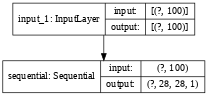

In [6]:
gen = create_generator()
gen.summary()
plot_model(gen, dpi=50, show_shapes=True, show_layer_names=True)

In [7]:
def create_discriminator():
  discriminator = Sequential()
  
  discriminator.add(Flatten(input_shape=img_shape))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(1, activation='sigmoid'))

  img = Input(shape=img_shape)
# Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img
  validity = discriminator(img) 
# Создаем модель discriminator (входные данные: img, выходные данные: validity)
  discriminator = Model(img, validity) 

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer = Adam(0.0002, 0.5), metrics=['accuracy'])

  return discriminator

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 533505    
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


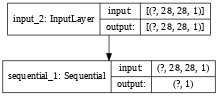

In [8]:
dis = create_discriminator()
dis.summary()
plot_model(dis, dpi=50, show_shapes=True, show_layer_names=True)

In [9]:
(X_train, _), (_, _) = mnist.load_data()

# Трансофрмируем значение в диапазон от -1 до 1
X_train = X_train / 127.5 - 1. 
# Добавляем третью размерность для X_train ((28,28) => (28,28,1))
X_train = np.expand_dims(X_train, axis=3)

11493376/11490434 [==============================] - 0s 0us/step


In [10]:
# Функция печати изображений
def sample_images(epoch, gen):
  r, c = 5, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))

  # Создаем картинку из шума
  noise = np.random.normal(0, 1, (r * c, latent_dim))
  gen_imgs = gen.predict(noise)
  gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r):
      for j in range(c):
        # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  plt.show()
  fig.savefig("images/%d.png" % epoch)
  plt.close()

In [21]:
def train(generator, discriminator, epochs=30000, batch_size=128):
  
  #Создайте yTrain - valid и fake для дисриминатора
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  #Создайте итоговую модель - combine - соединение генератора и дискриминатора
  discriminator.trainable = False  # Замораживаем обучение дискриматора - очень важно!!!
  # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  z = Input(shape=(latent_dim,))

  # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  img = generator(z)
  # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img
  validity = discriminator(img) 

  # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined = Model(z, validity)
  combined.compile(loss='binary_crossentropy',
                   optimizer = Adam(0.0002, 0.5))

  sample_interval = 2500
  
  d_loss_list = []
  g_loss_list = []
  d_acc_list = []
  
  for epoch in range(epochs):
    # Создайте случаные картинки для обучения дискриминатора ------------------------
    # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    idx = np.random.choice(X_train.shape[0], batch_size, replace=False) 
    imgs = X_train[idx]
    #Создайте картинки из шума для обучения генератора
    # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений
    noise = np.random.normal(0, 1, (batch_size, latent_dim)) 
    #Получите картинки на выходе генератора
    # Предиктим картинку с помощью входной переменной generator
    gen_imgs = generator.predict(noise) 
    
    #Обучите дискриминатор и получите ошибки -----------------------
    # Получаем ошибку дискриминатора, обученного на реальной картинке 
    #(для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    # Получаем ошибку дискриминатора, обученного на сгенерированной картинке 
    #(для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    # Получаем массив ошибок дискриминатора 
    #(поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

    #Обучите генератор ------------------------
    # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))
    g_loss = combined.train_on_batch(noise, valid) 
    #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # Добавляем в массив значений ошибок дискриматора первое значение в массиве d_loss
    d_loss_list.append(d_loss[0]) 
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    d_acc_list.append(100*d_loss[1]) 

    # Тренируем дискриминатор ---------------------
    # Добавляем в массив значений ошибок дискриматора первое значение в массиве d_loss
    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    d_acc_list.append(100*d_loss[1])
    
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)): # | - это ИЛИ
    #if epoch == epochs-1: #
        g_loss = combined.train_on_batch(noise, valid) 
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        sample_images(epoch, generator) # Вызываем функцию sample_images для печати изображений
        
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.grid()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.grid()
  plt.legend()
  plt.show()
    

## Обучение с активациями relu и LeakyReLU(alpha=0.2)

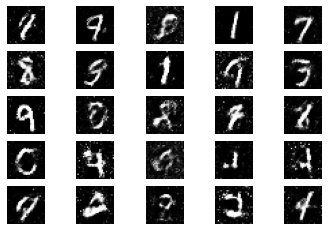

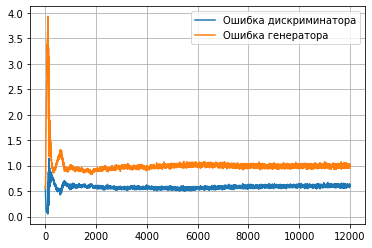

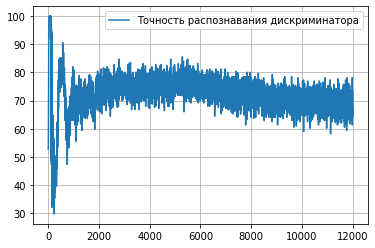

In [11]:
# С активацией relu 6000 эпох

# Вызываем функцию create_generator и записываем значение в переменную generator
generator = create_generator() 
# Вызываем функцию create_discriminator и записываем значение в переменную discriminator
discriminator = create_discriminator() 
# Вызываем функцию train с параметрами, generator, discriminator, 1000 (1000 - количество эпох)
train(generator, discriminator, 6000) 

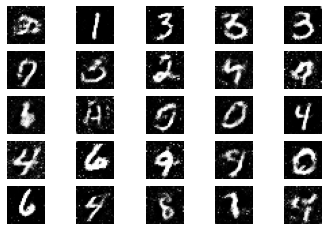

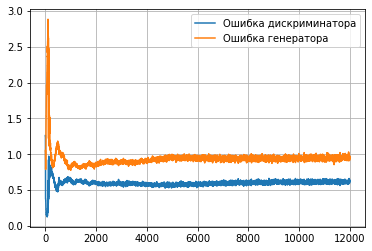

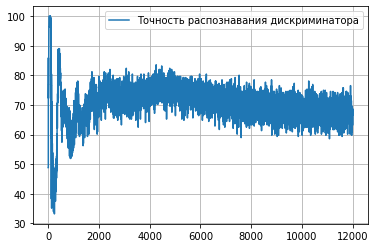

In [12]:
# С активацией LeakyReLU(alpha=0.2) на 6000 эпох
# Вызываем функцию create_generator и записываем значение в переменную generator
generator = create_generator() 
# Вызываем функцию create_discriminator и записываем значение в переменную discriminator
discriminator = create_discriminator() 
# Вызываем функцию train с параметрами, generator, discriminator, 1000 (1000 - количество эпох)
train(generator, discriminator, 6000) 

## Выводы:
1. GAV - очень нежная сеть и напрашивается какая-то автоматизация контроля и регулировки процесса взаимного обучения
2. Провел сравнение LeakyReLU и простого relu. Нужны более сложные изображения чтобы понять разницу
3. Провел эксперименты с разными Batchnormalization - все подобрано идеально. И правильно, что их нет в дискриминаторе )
4. Чуть упростил модель из урока - доп слой не влиял на качество

#Light задание. Вариант 2
-----
Используйте готовый ноутбук с занятия, генерируйте рукописные цифры
1. Запустите базовую генеративную сеть, с Dense генератором и дискриминатором - см вариант 1
2. Поменяйте размер внутреннего пространства генератора с 100 на 10 и 1000,
сравните результаты
3. Сделайте свёрточный генератор, сравните результаты с полносвязным
генератором
4. Сделайте возможность запускать обучение с разными batch_size для генератора и
дискриминатора, попробуйте запустить с batch_size 128 для дискриминатора и 256 для генератора, сравните результат с равными batch_size по 128

## Поменяйте размер внутреннего пространства генератора с 100 на 10 и 1000, сравните результаты

С активацией LeakyReLU(alpha=0.2):
latent_dim =  10 epoch =  1000


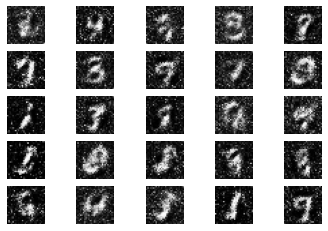

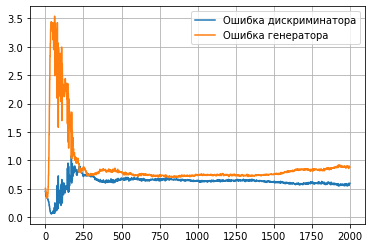

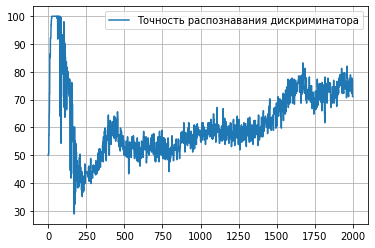

latent_dim =  100 epoch =  1000


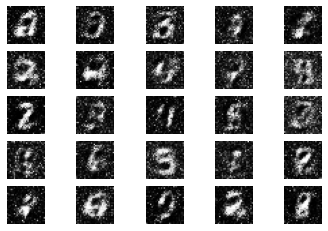

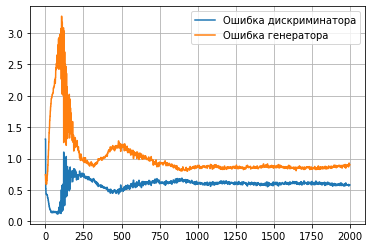

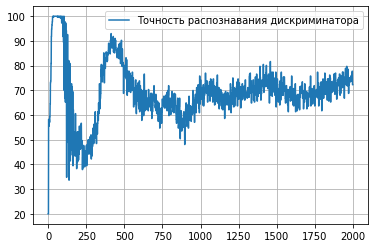

latent_dim =  1000 epoch =  1000


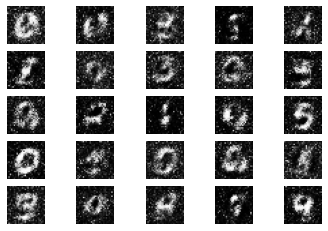

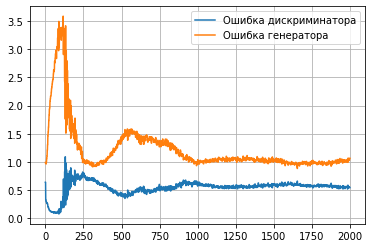

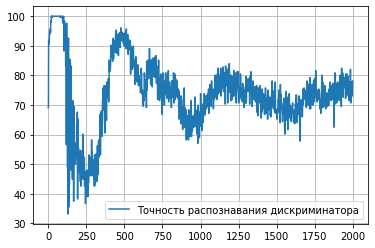

In [13]:
epoch = 1000
print('С активацией LeakyReLU(alpha=0.2):')
for latent_dim in [10, 100, 1000]:
  print ('latent_dim = ', latent_dim, 'epoch = ', epoch)
  generator = create_generator() 
  discriminator = create_discriminator() 
  train(generator, discriminator, epoch) 

### Выводы:
С увеличеснием скрытого слоя генератор учится ХУЖЕ дискриминатора. О чем говорит увеличившееся расстояние между их ошибками на графиках.

Качество генерации падает. что хорошо аметно на малом количестве эпох

## Сделайте свёрточный генератор, сравните результаты с полносвязным генератором

### Самостоятельные изыскания

In [22]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 28, 28, 1)         1776113   
Total params: 1,776,113
Trainable params: 1,764,625
Non-trainable params: 11,488
_________________________________________________________________


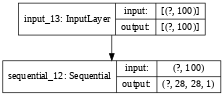

In [23]:
def create_generator():
  generator = Sequential()

  generator.add(Dense(28*28*7, input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Reshape((28, 28, 7)))

  generator.add(Conv2DTranspose(256, (3,3), padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Conv2DTranspose(256, (3,3), padding="same"))
  generator.add(LeakyReLU(alpha=0.2))

  generator.add(Conv2DTranspose(256, (3,3), padding="same"))
  generator.add(LeakyReLU(alpha=0.2))

  generator.add(Conv2DTranspose(1, (3,3), padding="same", strides=1))
  generator.add(LeakyReLU(alpha=0.2))


# Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  noise = Input(shape=(latent_dim,))
# Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise
  img = generator(noise)
# создаем модель generator (входные данные: noise, выходные данные: img)
  generator = Model(noise, img) 

  return generator

gen = create_generator()
gen.summary()
plot_model(gen, dpi=50, show_shapes=True, show_layer_names=True)

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 1)                 11211     
Total params: 11,211
Trainable params: 11,211
Non-trainable params: 0
_________________________________________________________________


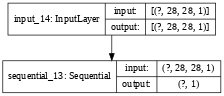

In [24]:
def create_discriminator():
  discriminator = Sequential()

  discriminator.add(Conv2D(1, (3,3), input_shape=img_shape)) 
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Conv2D(16, (3,3)))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Conv2D(16, (3,3)))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Conv2D(16, (3,3)))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Flatten())
  #discriminator.add(Dense(latent_dim))
  #discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(1, activation='sigmoid'))

# Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  img = Input(shape=img_shape)
# Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img
  validity = discriminator(img) 
# Создаем модель discriminator (входные данные: img, выходные данные: validity)
  discriminator = Model(img, validity) 

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer = Adam(0.0002, 0.5), metrics=['accuracy'])

  return discriminator

dis = create_discriminator()
dis.summary()
plot_model(dis, dpi=50, show_shapes=True, show_layer_names=True)

Самостоятельно спроектированная нейросеть
latent_dim =  10 epoch =  10000
0 [D loss: 0.688948, acc.: 41.80%] [G loss: 0.630880]


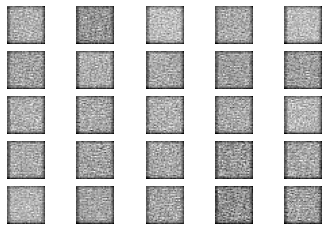

2500 [D loss: 0.680912, acc.: 69.14%] [G loss: 0.739547]


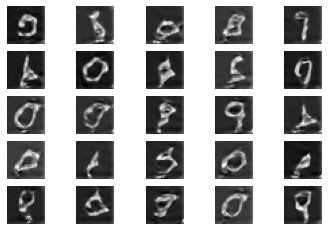

5000 [D loss: 0.553895, acc.: 82.81%] [G loss: 0.741630]


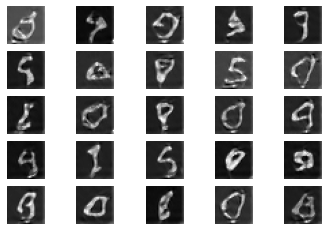

7500 [D loss: 0.562143, acc.: 69.14%] [G loss: 1.422585]


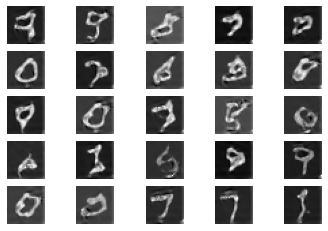

9999 [D loss: 0.643155, acc.: 55.86%] [G loss: 1.080501]


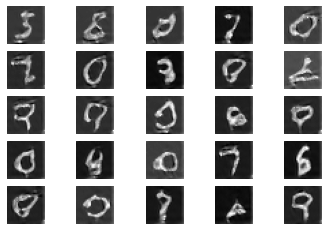

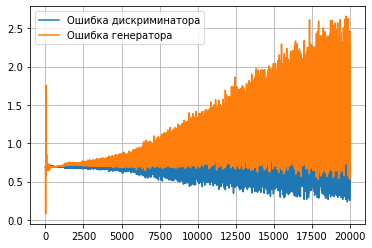

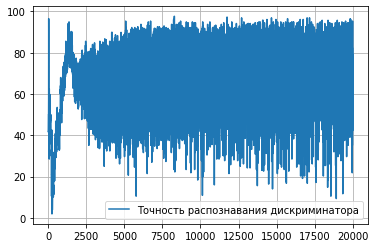

latent_dim =  100 epoch =  10000
0 [D loss: 0.701367, acc.: 9.77%] [G loss: 0.637156]


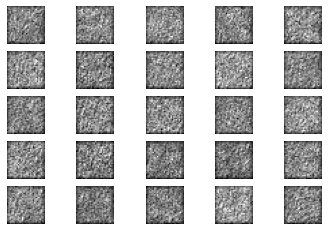

2500 [D loss: 0.693715, acc.: 51.95%] [G loss: 0.732836]


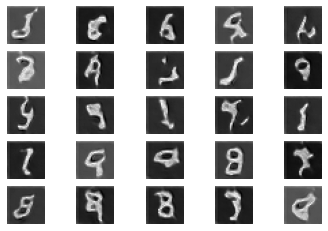

5000 [D loss: 0.667258, acc.: 76.95%] [G loss: 0.755227]


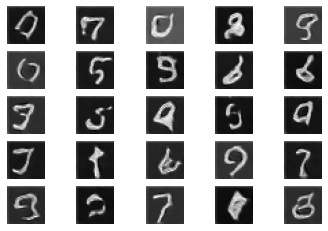

7500 [D loss: 0.639328, acc.: 58.59%] [G loss: 0.733053]


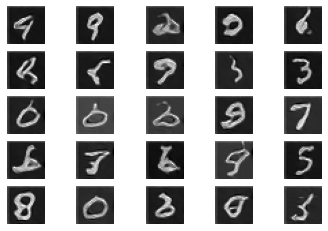

9999 [D loss: 0.521739, acc.: 86.33%] [G loss: 1.791973]


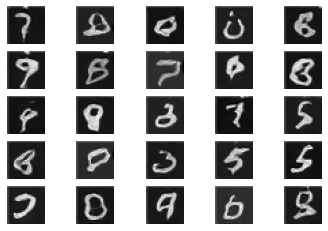

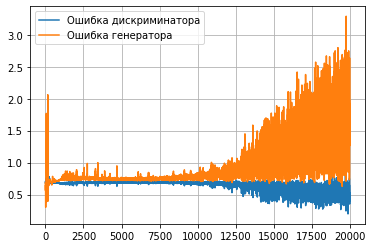

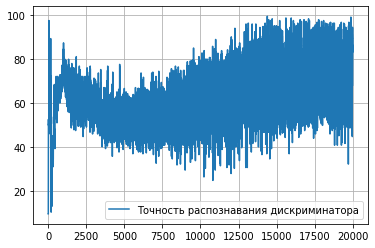

latent_dim =  1000 epoch =  10000
0 [D loss: 0.695658, acc.: 34.38%] [G loss: 0.680376]


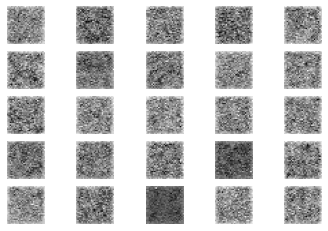

2500 [D loss: 0.683485, acc.: 54.30%] [G loss: 0.700902]


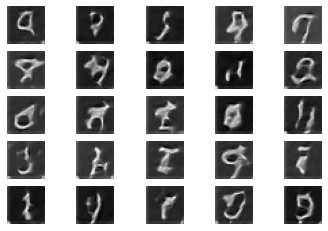

5000 [D loss: 0.599203, acc.: 83.20%] [G loss: 0.855820]


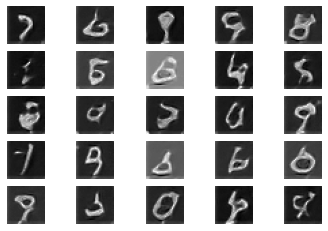

7500 [D loss: 0.488541, acc.: 69.53%] [G loss: 0.821540]


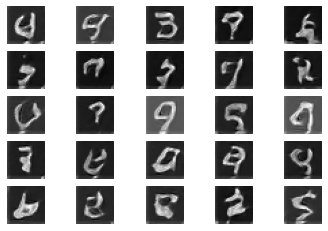

9999 [D loss: 0.321891, acc.: 89.06%] [G loss: 2.757596]


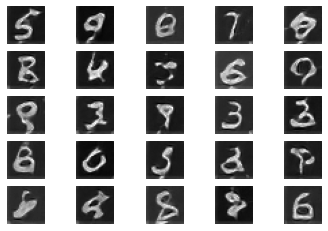

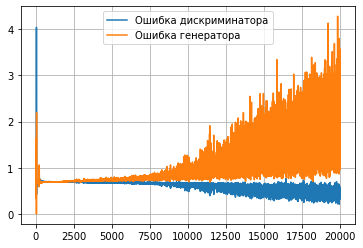

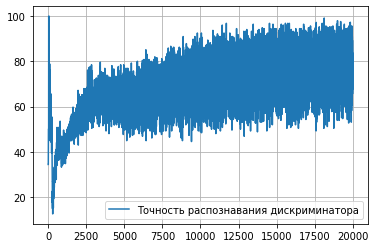

In [25]:
# После сверточных словев поставил в дискриминатор слой Dense(latent_dim)
epoch = 10000
print('Самостоятельно спроектированная нейросеть')
for latent_dim in [10, 100, 1000]:
  print ('latent_dim = ', latent_dim, 'epoch = ', epoch)
  generator = create_generator() 
  discriminator = create_discriminator() 
  train(generator, discriminator, epoch)

### Продолжение по статье:
-----
https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f

In [26]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

optimizer = Adam(0.0002, 0.5)

In [27]:
def create_generator():
  generator = Sequential()

  d = 7
  generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=latent_dim))
  generator.add(LeakyReLU(0.2))
  # 7x7x256
  generator.add(Reshape((d, d, 256)))
    
  # 14x14x128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
    
  # 28x28*128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
    
  # 28x28*64
  generator.add(Conv2DTranspose(64, (4, 4), strides=1, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
    
  # 28x28x1
  generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
    
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generator

# Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  noise = Input(shape=(latent_dim,))
# Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise
  img = generator(noise)
# создаем модель generator (входные данные: noise, выходные данные: img)
  generator = Model(noise, img) 

  return generator

gen = create_generator()
gen.summary()
#plot_model(gen, dpi=50, show_shapes=True, show_layer_names=True)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 14, 14, 128)       524416    
_________________________________________________________________
leaky_re_lu_83 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 28, 28, 128)     

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_21 (Sequential)   (None, 1)                 11211     
Total params: 11,211
Trainable params: 11,211
Non-trainable params: 0
_________________________________________________________________


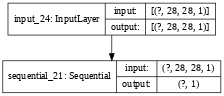

In [28]:
def create_descriminator():
  discriminator = Sequential()
    
  discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
  discriminator.add(LeakyReLU(0.2))
    
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
    
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
    
  discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
    
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
# Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  img = Input(shape=img_shape)
# Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img
  validity = discriminator(img) 
# Создаем модель discriminator (входные данные: img, выходные данные: validity)
  discriminator = Model(img, validity) 

  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,
                        metrics=['accuracy'])
    
  return discriminator

dis = create_discriminator()
dis.summary()
plot_model(dis, dpi=50, show_shapes=True, show_layer_names=True)

Нейросеть, адаптированная из статьи 
https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f
latent_dim =  10 epoch =  10000
0 [D loss: 0.687440, acc.: 36.72%] [G loss: 0.692460]


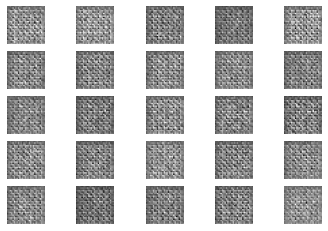

2500 [D loss: 0.700392, acc.: 24.22%] [G loss: 0.692865]


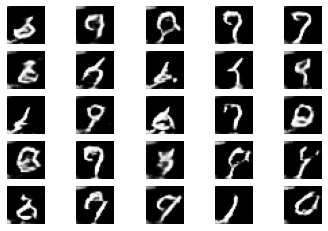

5000 [D loss: 0.695472, acc.: 24.22%] [G loss: 0.691698]


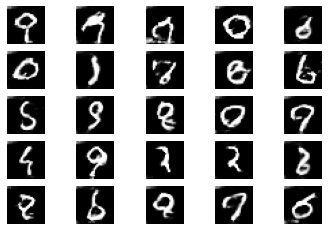

7500 [D loss: 0.693658, acc.: 44.14%] [G loss: 0.692200]


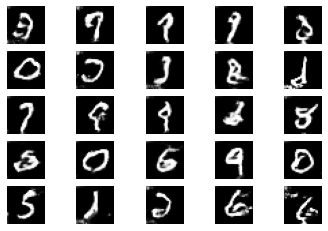

9999 [D loss: 0.693395, acc.: 42.19%] [G loss: 0.692299]


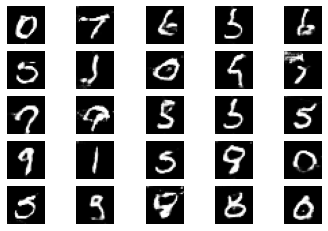

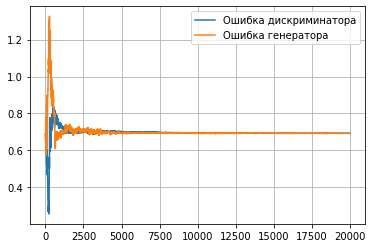

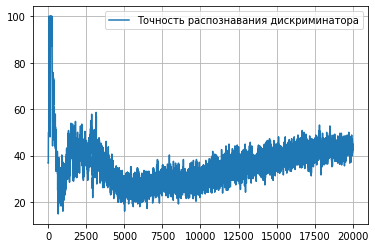

latent_dim =  100 epoch =  10000
0 [D loss: 0.657929, acc.: 50.00%] [G loss: 0.691444]


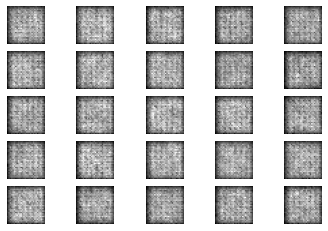

2500 [D loss: 0.696038, acc.: 43.75%] [G loss: 0.689501]


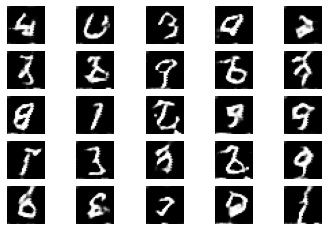

5000 [D loss: 0.693398, acc.: 52.73%] [G loss: 0.691677]


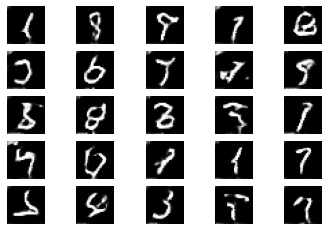

7500 [D loss: 0.693758, acc.: 43.36%] [G loss: 0.693479]


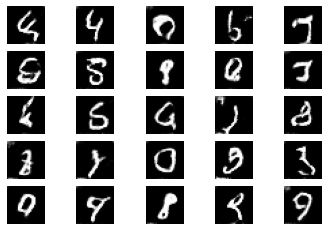

9999 [D loss: 0.693859, acc.: 45.31%] [G loss: 0.692639]


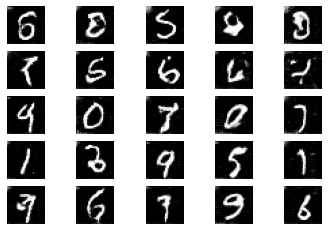

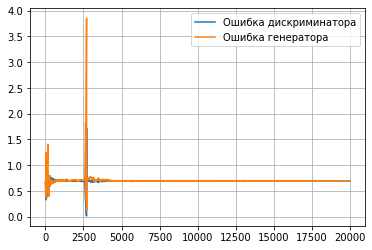

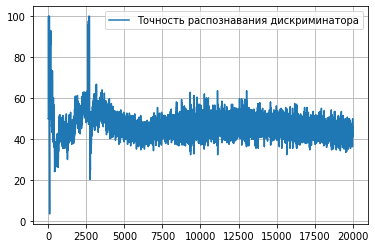

latent_dim =  1000 epoch =  10000
0 [D loss: 0.743584, acc.: 22.27%] [G loss: 0.689949]


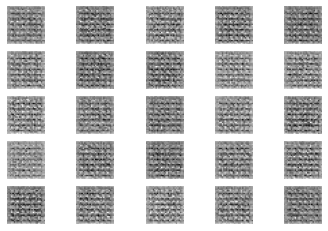

2500 [D loss: 0.700348, acc.: 46.88%] [G loss: 0.686721]


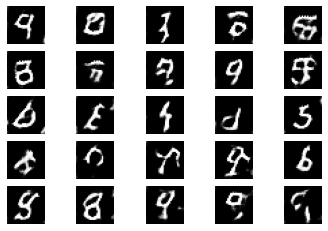

5000 [D loss: 0.691820, acc.: 53.12%] [G loss: 0.687521]


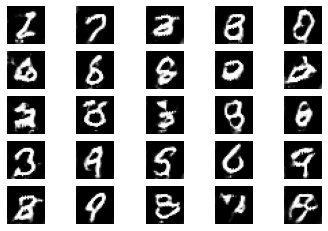

7500 [D loss: 0.694064, acc.: 47.66%] [G loss: 0.686741]


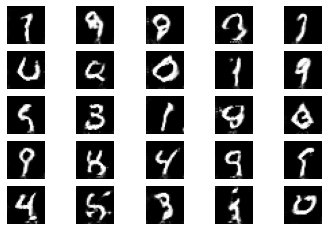

9999 [D loss: 0.694884, acc.: 46.48%] [G loss: 0.687900]


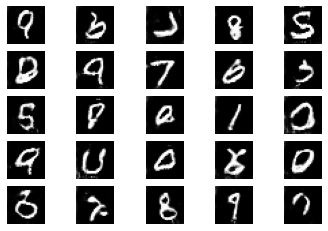

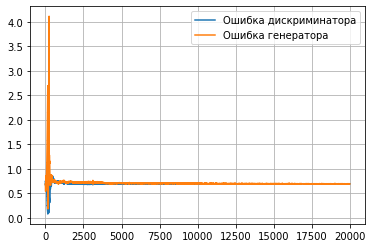

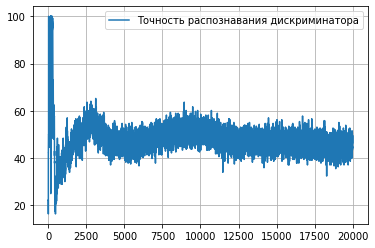

In [29]:
# После сверточных словев поставил в дискриминатор слой Dense(latent_dim)
epoch = 10000
print('Нейросеть, адаптированная из статьи \nhttps://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f')
for latent_dim in [10, 100, 1000]:
  print ('latent_dim = ', latent_dim, 'epoch = ', epoch)
  generator = create_generator() 
  discriminator = create_discriminator() 
  train(generator, discriminator, epoch)

### Образец неудачной сети с красивыми графиками
Думаю, что проблема в accuracy дискриминатора, прилипшего к 0.5

Model: "functional_679"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_354 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_345 (Sequential)  (None, 1)                 790       
Total params: 790
Trainable params: 790
Non-trainable params: 0
_________________________________________________________________


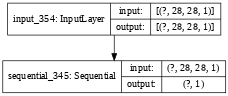

In [354]:
def create_discriminator():
  discriminator = Sequential()

  discriminator.add(Conv2DTranspose(1, (2,2), padding="same", input_shape=img_shape)) 
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Flatten())
  #discriminator.add(Dense(latent_dim))
  #discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(1, activation='sigmoid'))

# Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  img = Input(shape=img_shape)
# Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img
  validity = discriminator(img) 
# Создаем модель discriminator (входные данные: img, выходные данные: validity)
  discriminator = Model(img, validity) 

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer = Adam(0.0002, 0.5), metrics=['accuracy'])

  return discriminator

dis = create_discriminator()
dis.summary()
plot_model(dis, dpi=50, show_shapes=True, show_layer_names=True)

Model: "functional_681"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_355 (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
sequential_346 (Sequential)  (None, 28, 28, 1)         668737    
Total params: 668,737
Trainable params: 656,191
Non-trainable params: 12,546
_________________________________________________________________


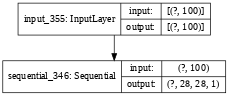

In [355]:
def create_generator():
  generator = Sequential()

  generator.add(Dense(latent_dim, input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  #generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(28*28*8))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Reshape((28, 28, 8)))

  generator.add(Conv2D(1, (3,3), padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

# Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  noise = Input(shape=(latent_dim,))
# Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise
  img = generator(noise)
# создаем модель generator (входные данные: noise, выходные данные: img)
  generator = Model(noise, img) 

  return generator

gen = create_generator()
gen.summary()
plot_model(gen, dpi=50, show_shapes=True, show_layer_names=True)

С активацией LeakyReLU(alpha=0.2)
latent_dim =  100 epoch =  6000


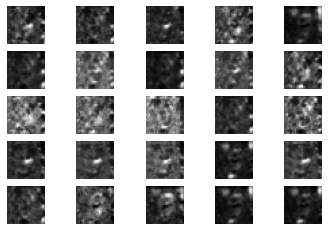

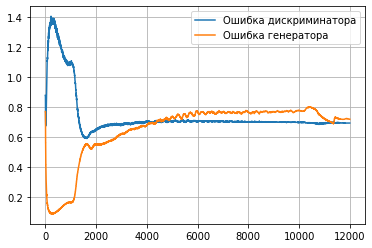

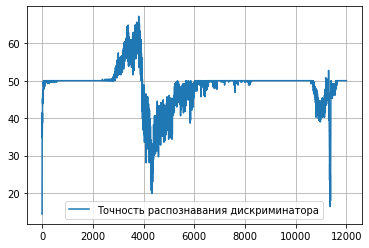

In [356]:
# После сверточных словев поставил в дискриминатор слой Dense(latent_dim)
epoch = 6000
print('С активацией LeakyReLU(alpha=0.2)')
for latent_dim in [100]:
  print ('latent_dim = ', latent_dim, 'epoch = ', epoch)
  generator = create_generator() 
  discriminator = create_discriminator() 
  train(generator, discriminator, epoch) 

 ### И как это интерпретировать? 
 ----
 Поскольку в свертках есть Dense слой с latent_dim, то я так понимаю6 что всю работу делает он, а не свертки

## Сделайте возможность запускать обучение с разными batch_size для генератора и дискриминатора,
попробуйте запустить с batch_size 128 для дискриминатора и 256 для генератора, сравните результат с равными batch_size по 128

In [14]:
batch_size = 128 # Размер batch_size для дискриминатора
batch_size_gen = 1024 # Для генератора
latent_dim = 100

In [17]:
def train(generator, discriminator, epochs=30000, batch_size=128):
  
  #Создайте yTrain - valid и fake
  valid = np.ones((batch_size, 1))
  valid_gen = np.ones((batch_size_gen, 1))  # Для другого батча для генератора
  fake = np.zeros((batch_size, 1))

  #Создайте итоговую модель - combine - соединение генератора и дискриминатора
  discriminator.trainable = False  # Замораживаем обучение дискриматора - очень важно!!!
  # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  z = Input(shape=(latent_dim,))

  # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  img = generator(z)
  # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img
  validity = discriminator(img) 

  # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined = Model(z, validity)
  combined.compile(loss='binary_crossentropy',
                   optimizer = Adam(0.0002, 0.5))

  sample_interval = 200
  
  d_loss_list = []
  g_loss_list = []
  d_acc_list = []
  
  for epoch in range(epochs):
    # Создайте случаные картинки для обучения дискриминатора ------------------------
    # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    idx = np.random.choice(X_train.shape[0], batch_size, replace=False) 
    imgs = X_train[idx]
    #Создайте картинки из шума для обучения генератора
    # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    noise_gen = np.random.normal(0, 1, (batch_size_gen, latent_dim))  # Для другого батча для генератора
    # Предиктим картинку с помощью входной переменной generator
    gen_imgs = generator.predict(noise) 
    
    #Обучите дискриминатор и получите ошибки -----------------------
    # Получаем ошибку дискриминатора, обученного на реальной картинке 
    #(для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    # Получаем ошибку дискриминатора, обученного на сгенерированной картинке 
    #(для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    # Получаем массив ошибок дискриминатора 
    #(поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

    #Обучите генератор -------------------------------------------------------------------------------
    # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))
    g_loss = combined.train_on_batch(noise_gen, valid_gen) 
    #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # Добавляем в массив значений ошибок дискриматора первое значение в массиве d_loss
    d_loss_list.append(d_loss[0]) 
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    d_acc_list.append(100*d_loss[1]) 

    # Тренируем дискриминатор ---------------------
    # Добавляем в массив значений ошибок дискриматора первое значение в массиве d_loss
    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    d_acc_list.append(100*d_loss[1])
    
    # Проверяем на условие вывода информации раз в sample_interval эпох
    #if ((epoch % sample_interval == 0) | (epoch == epochs-1)): # | - это ИЛИ
    if epoch == epochs-1: # | - это ИЛИ
        sample_images(epoch, generator) # Вызываем функцию sample_images для печати изображений
        
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.grid()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.grid()
  plt.legend()
  plt.show()


С активацией LeakyReLU(alpha=0.2)
batch_size дискриминатора =  128 	batch_size генератора =  1024
latent_dim =  10 epoch =  6000


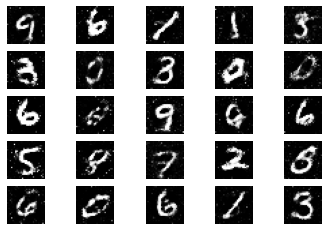

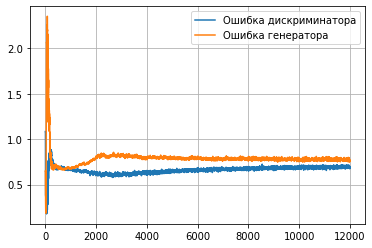

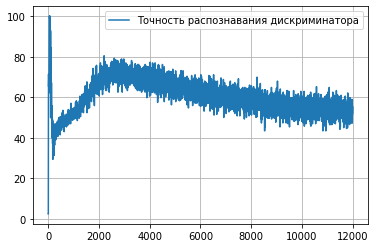

latent_dim =  100 epoch =  6000


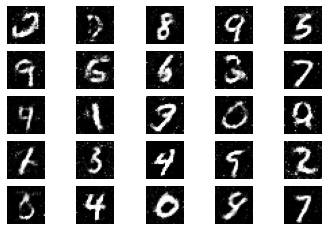

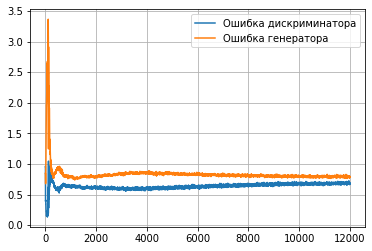

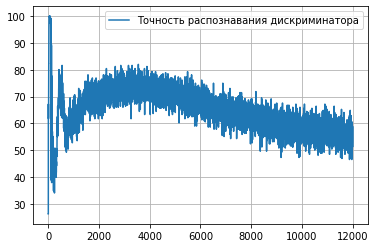

latent_dim =  1000 epoch =  6000


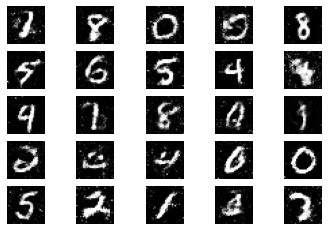

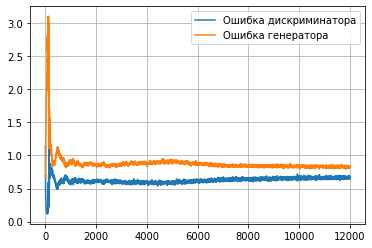

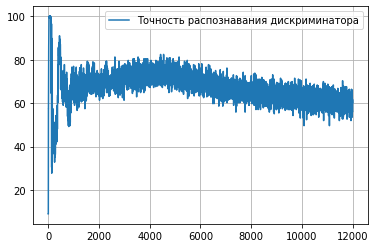

In [16]:
epoch = 6000
print('С активацией LeakyReLU(alpha=0.2)\nbatch_size дискриминатора = ', batch_size,
      '\tbatch_size генератора = ', batch_size_gen)
for latent_dim in [10, 100, 1000]:
  print ('latent_dim = ', latent_dim, 'epoch = ', epoch)
  generator = create_generator() 
  discriminator = create_discriminator() 
  train(generator, discriminator, epoch) 

### Вывод:
1. Чтобы понять разницу, увеличил батч не до 256, а до 1024 - привые ошибок сошлись, что должно быть очень круто, как я понимаю

2. Идеальное сочетание: batch=1024 и dim=100